In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
class Dataset_Handler():
    def __init__(self,sequence,low_memory=True):
        self.low_memory=low_memory
        self.seq_dir = f'/Users/niramaypatel/Desktop/RBCV/dataset/sequences/{sequence}/'
        self.pos_dir = f'/Users/niramaypatel/Desktop/RBCV/poses/{sequence}.txt'
        poses=pd.read_csv(self.pos_dir,delimiter=" ",header=None)
        self.left_img_files=sorted(os.listdir(self.seq_dir+'image_0'),key=lambda x: int(x.split(".")[0]))
        self.right_img_files=sorted(os.listdir(self.seq_dir+'image_1'),key=lambda x: int(x.split(".")[0]))
        self.num_frames=len(self.left_img_files)
        calib = pd.read_csv(self.seq_dir+'calib.txt',delimiter=" ",header=None)
        # self.P0 = np.array(calib.loc['P0']).reshape((3,4))
        # self.P1 = np.array(calib.loc['P1'])t.reshape((3,4))
        self.P0=np.array(calib.iloc[0][1:]).reshape((3,4))
        self.P1=np.array(calib.iloc[0][1:]).reshape((3,4))

        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt',delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        if self.low_memory:
            self.reset_frames()
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_img_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_img_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_img_files[1], 0)
            self.imwidth=self.first_image_left.shape[0]
            self.imheight=self.first_image_left.shape[1]
        
    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_img_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_img_files)  
        pass
                                 

In [3]:
handler = Dataset_Handler('00')

In [4]:
%matplotlib inline

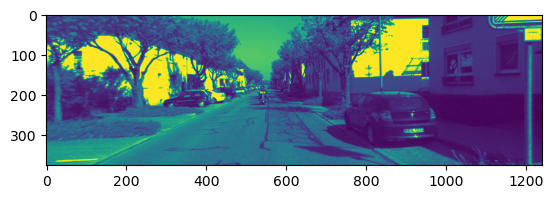

In [5]:
plt.imshow(handler.first_image_left)

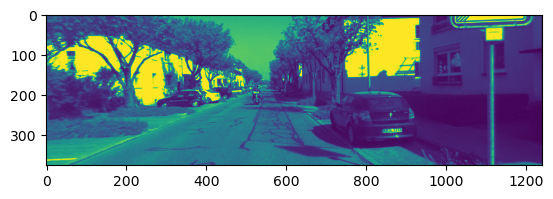

In [6]:
plt.imshow(handler.first_image_right)

In [7]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left=cv2.cvtColor(img_left,cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [8]:
%matplotlib inline

Time to compute disparity map using StereoBM: 0:00:00.023685


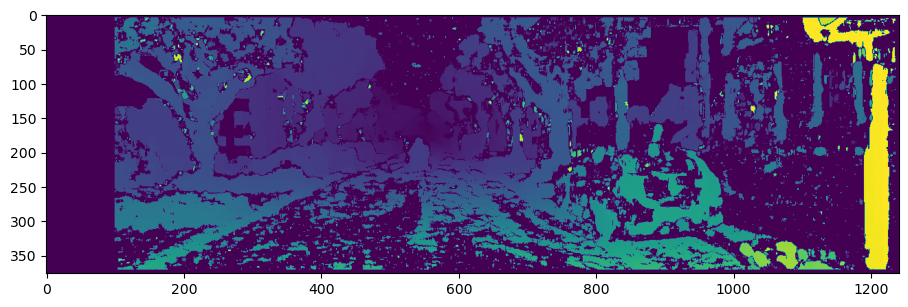

In [9]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Time to compute disparity map using StereoSGBM: 0:00:00.037514


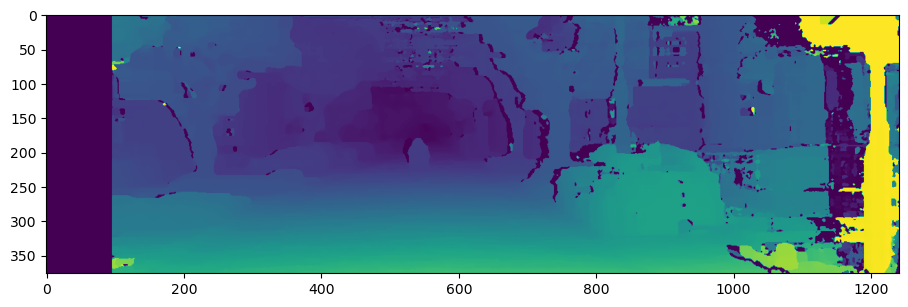

In [10]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

In [11]:
handler.P0

array([[718.856, 0.0, 607.1928, 0.0],
       [0.0, 718.856, 185.2157, 0.0],
       [0.0, 0.0, 1.0, 0.0]], dtype=object)

In [15]:
k,r,t,_,_,_,_ = cv2.decomposeProjectionMatrix(np.float32(handler.P1))
print(k)
print(r)
print(t)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.]
 [0.]
 [0.]
 [1.]]


In [16]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [17]:
def calc_norm_depth(disp_left,k_left,t_left,t_right,rectified=True):
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [18]:
k_left, r_left, t_left = decompose_projection_matrix(np.float32(handler.P0))
k_right, r_right, t_right = decompose_projection_matrix(np.float32(handler.P1))

In [19]:
t_right[0]=0.54

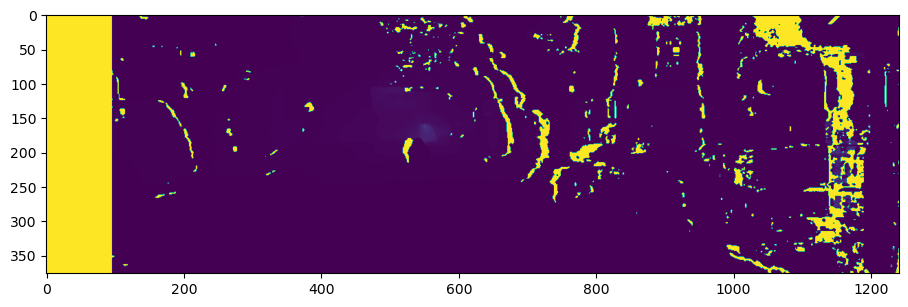

In [20]:
depth = calc_norm_depth(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

(array([405883.,    646.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  60087.]),
 array([   4.08612919,  391.85977173,  779.63342285, 1167.40698242,
        1555.18066406, 1942.9543457 , 2330.72802734, 2718.50170898,
        3106.27514648, 3494.04882812, 3881.82250977]),
 <BarContainer object of 10 artists>)

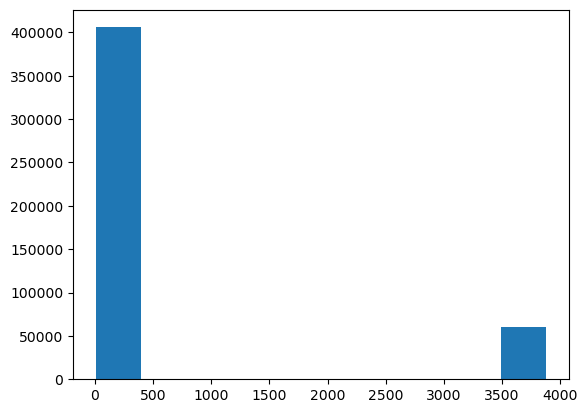

In [21]:
plt.hist(depth.flatten())

In [22]:
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


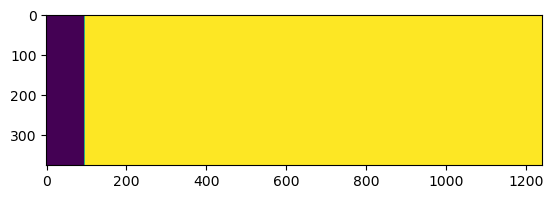

In [23]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [24]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(np.float32(P0))
    k_right, r_right, t_right = decompose_projection_matrix(np.float32(P1))
    # Calculate depth map for left camera
    depth = calc_norm_depth(disp, k_left, t_left, t_right)
    
    return depth

In [25]:
def extract_features(image,detector='orb',mask=None):
    if detector=='sift':
        det=cv2.SIFT_create()
    elif detector=='orb':
        det=cv2.ORB_create()
    kp, des = det.detectAndCompute(image, mask)
    return kp,des

In [26]:
def match_features(des1,des2,matching="BF",detector="sift",sort=True,k=2):
    if matching == "BF":
        if detector=="sift":
            matcher=cv2.BFMatcher_create(cv2.NORM_L2,crossCheck=False)
        elif detector=="orb":
            matcher=cv2.BFMatcher_create(cv2.NORM_HAMMING2,crossCheck=False)
    elif matching == 'FLANN':
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(des1, des2, k=k)
    if sort:
        matches=sorted(matches,key=lambda x:x[0].distance)
    return matches
    

In [27]:
def visualize_matches(image_1,kp1,image_2,kp2,match):
    image_matches = cv2.drawMatches(image_1, kp1, image_2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [28]:
def filter_matches_distance(matches,dist_threshold=0.5):
    filtered_matches=[]
    for m,n in matches:
        if (m.distance/n.distance)<=dist_threshold:
            filtered_matches.append(m)
    return filtered_matches

In [29]:
%matplotlib inline

Number of matches before filtering:  500
Number of matches after filtering:  19
Time to match and filter:  0:00:00.107957


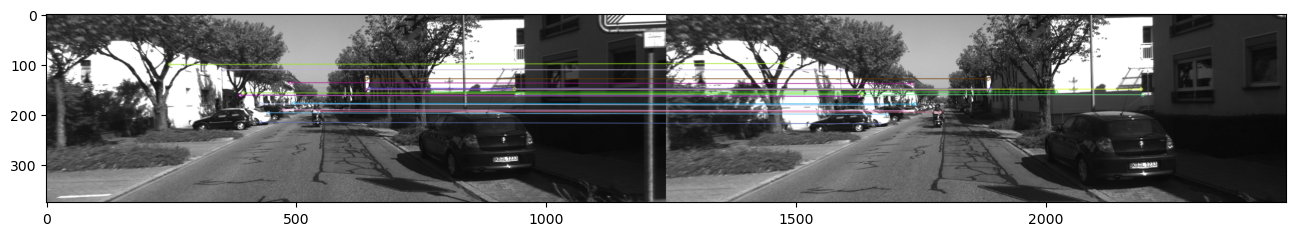

In [30]:
# Using the orb features/descriptors
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now()
kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_plus1, 'orb', mask)
matches = match_features(des0, des1, matching='BF', detector='orb', sort=False)
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [31]:

def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    object_points = np.zeros((0, 3))
    delete = []
    
    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(round(v)), int(round(u))]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        object_points = np.vstack([object_points, np.array([x, y, z])])
        #object_points = np.vstack([obeject_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])
        
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [32]:
k,r,t,_,_,_,_=cv2.decomposeProjectionMatrix(np.float32(handler.P0))
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]], dtype=float32)

In [33]:
rmat,tvec,image1_points,image2_points=estimate_motion(matches,kp0,kp1,k,depth)
print(f"Rotation Matrix: \n {rmat.round(4)}")
print(f"Translation Vector: \n {tvec.round(4)}")

Rotation Matrix: 
 [[ 1.      0.002   0.0034]
 [-0.002   1.      0.0028]
 [-0.0034 -0.0029  1.    ]]
Translation Vector: 
 [[-0.0086]
 [-0.0196]
 [-0.7043]]


In [34]:
transformation_matrix=np.hstack([rmat,tvec])
print(transformation_matrix.round(4))

[[ 1.      0.002   0.0034 -0.0086]
 [-0.002   1.      0.0028 -0.0196]
 [-0.0034 -0.0029  1.     -0.7043]]


In [35]:
print(handler.gt[1].round(4))


[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [36]:
hom_trans_mat = np.eye(4)
hom_trans_mat[:3, :3] = rmat
hom_trans_mat[:3, 3] = tvec.T
hom_trans_mat.round(4)

array([[ 1.    ,  0.002 ,  0.0034, -0.0086],
       [-0.002 ,  1.    ,  0.0028, -0.0196],
       [-0.0034, -0.0029,  1.    , -0.7043],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [37]:
np.linalg.inv(hom_trans_mat)

array([[ 0.99999204, -0.00204937, -0.00342225,  0.00613423],
       [ 0.00203962,  0.99999386, -0.00285065,  0.01756159],
       [ 0.00342807,  0.00284365,  0.99999008,  0.70440927],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [38]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
   
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(np.float32(handler.P0))
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Supercede stereo depth estimations where lidar points are available
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            lidar_depth = pointcloud2image(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth < 3000)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)

        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [39]:
def calculate_error(ground_truth, estimated, error_type='mse'):
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

In [40]:
# See what kind of results we get without using LIDAR correction on depth
# We will use StereoBM to do depth estimate, since it is faster than StereoSGBM, then compare
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        #matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.175180
Time to compute frame 2: 0:00:00.147702
Time to compute frame 3: 0:00:00.149193
Time to compute frame 4: 0:00:00.152732
Time to compute frame 5: 0:00:00.157322
Time to compute frame 6: 0:00:00.153752
Time to compute frame 7: 0:00:00.153450
Time to compute frame 8: 0:00:00.153897
Time to compute frame 9: 0:00:00.148435
Time to compute frame 10: 0:00:00.147913
Time to compute frame 11: 0:00:00.145451
Time to compute frame 12: 0:00:00.143296
Time to compute frame 13: 0:00:00.141074
Time to compute frame 14: 0:00:00.132273
Time to compute frame 15: 0:00:00.137142
Time to compute frame 16: 0:00:00.146035
Time to compute frame 17: 0:00:00.137009
Time to compute frame 18: 0:00:00.132568
Time to compute frame 19: 0:00:00.139539
Time to compute frame 20: 0:00:00.142819
Time to compute frame 21: 0:00:00.143973
Time t

In [41]:
%matplotlib widget

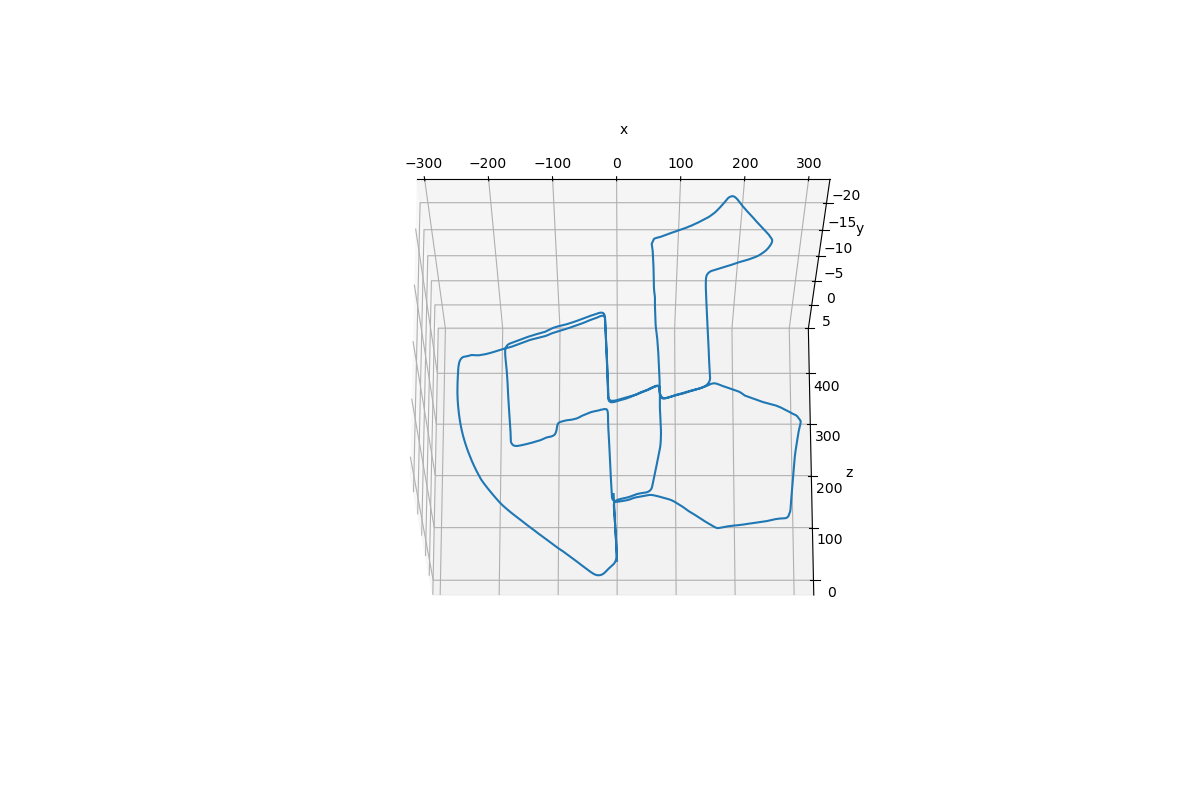

In [42]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)